In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'PANNs'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA01_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
1
RZUA02
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA02_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
2
RZUA04
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA04_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=tor

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 2048])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True


2048

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del graphs, x, unpacked_data, train_dataset

## Crear modelo y entrenar

In [12]:
from models import MatrixGCNVAE, MatrixGATVAE

In [13]:
model = MatrixGCNVAE(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #0.01 GCN

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        node_reconstruction, adj_reconstruction, mu, logvar = model(graph.x.double(), graph.edge_index)
        loss, feature_loss, adj_loss, kl_loss = model.loss_function(node_reconstruction, adj_reconstruction, graph.x.double(),
                                                                    graph.edge_index, mu, logvar, alpha=1.0, beta=0.1)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 101):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 020, Loss: 23124.2835
Epoch: 040, Loss: 17017.5492
Epoch: 060, Loss: 13673.5466
Epoch: 080, Loss: 11383.7577
Epoch: 100, Loss: 9457.2069


In [14]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar = model(graph.x.double(), graph.edge_index)
        embeddings = model.reparameterize(mu, logvar)

In [15]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 256])


In [16]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [17]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)
sim_mat

array([[99.53491678, 90.35912365, 74.8668414 , ..., 72.70621077,
        74.18769619, 70.83762192],
       [90.35912365, 94.73464764, 72.31378129, ..., 70.59351899,
        70.66654712, 68.6125178 ],
       [74.8668414 , 72.31378129, 74.73469987, ..., 69.47505681,
        68.13474612, 68.61367102],
       ...,
       [72.70621077, 70.59351899, 69.47505681, ..., 75.25527542,
        68.66472194, 67.94088827],
       [74.18769619, 70.66654712, 68.13474612, ..., 68.66472194,
        74.65913124, 66.78475171],
       [70.83762192, 68.6125178 , 68.61367102, ..., 67.94088827,
        66.78475171, 71.29644904]])

In [18]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [20]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

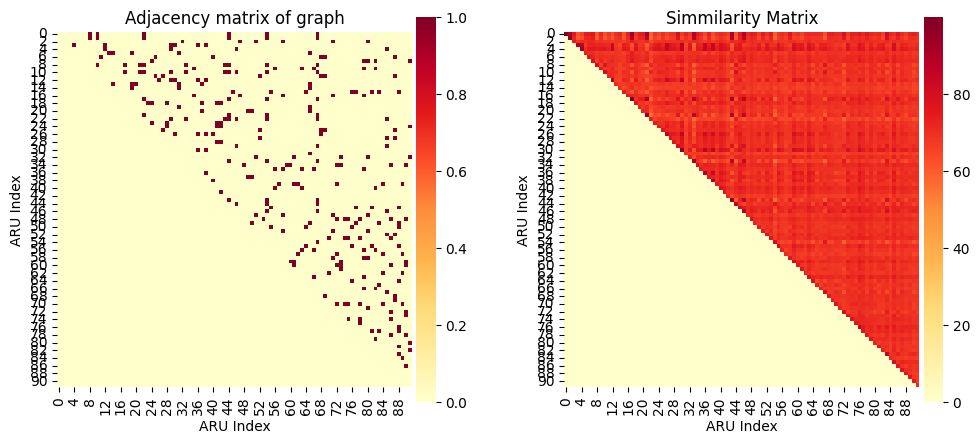

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

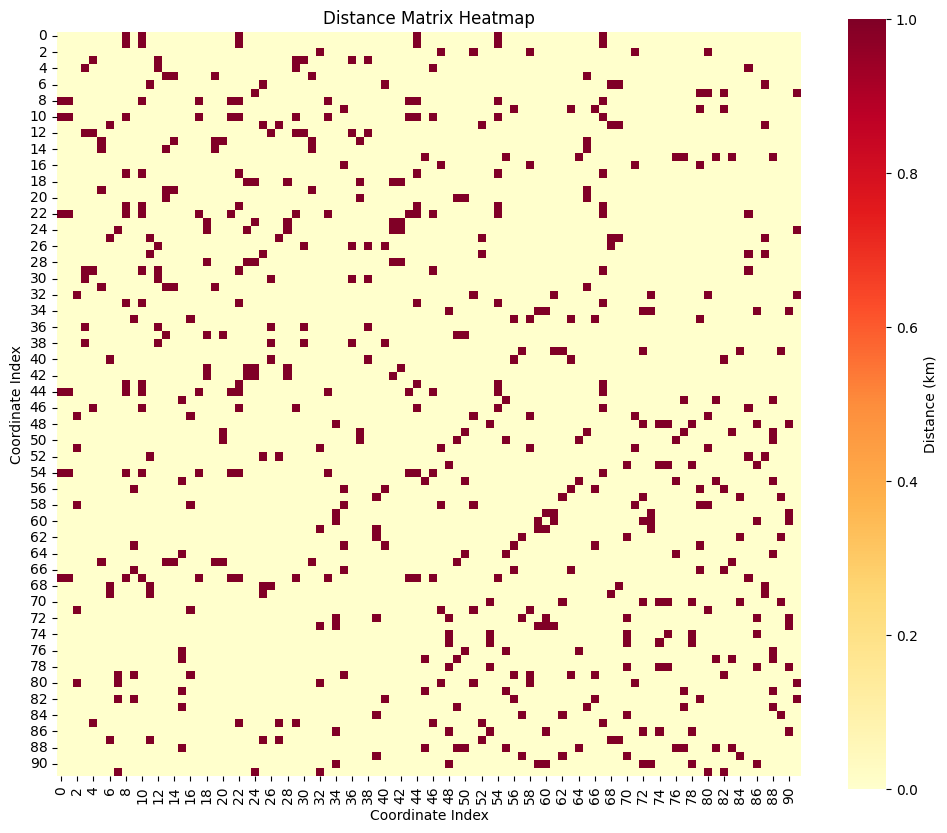

In [22]:
plot_distance_matrix_heatmap(adj_graph)

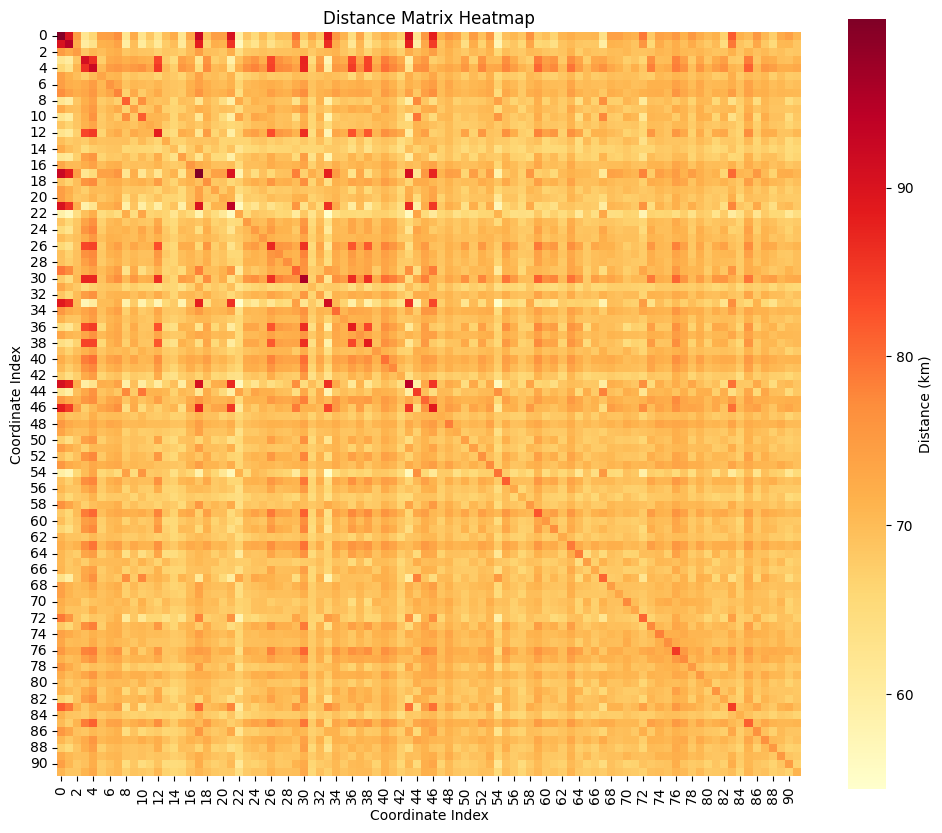

In [23]:
plot_distance_matrix_heatmap(sim_mat)

In [24]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

69.9045605720488


In [25]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [26]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

591672.200681821


In [27]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

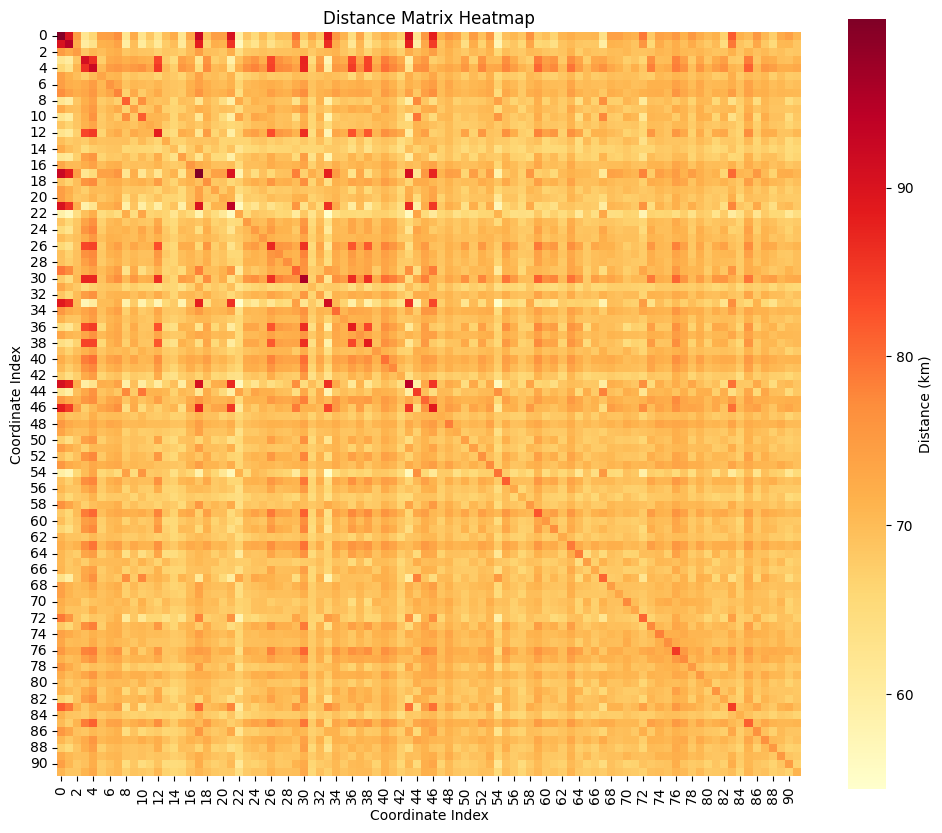

In [28]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [29]:
# diameter
print(np.max(dist_matrix))

99.97599709642836


In [30]:
#average path
print(np.mean(dist_matrix))

69.9045605720488


In [31]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

0.0


In [32]:
dist_matrix

array([[99.53491678, 90.35912365, 74.8668414 , ..., 72.70621077,
        74.18769619, 70.83762192],
       [90.35912365, 94.73464764, 72.31378129, ..., 70.59351899,
        70.66654712, 68.6125178 ],
       [74.8668414 , 72.31378129, 74.73469987, ..., 69.47505681,
        68.13474612, 68.61367102],
       ...,
       [72.70621077, 70.59351899, 69.47505681, ..., 75.25527542,
        68.66472194, 67.94088827],
       [74.18769619, 70.66654712, 68.13474612, ..., 68.66472194,
        74.65913124, 66.78475171],
       [70.83762192, 68.6125178 , 68.61367102, ..., 67.94088827,
        66.78475171, 71.29644904]])

## Fin